In [21]:
# %pip install ipykernel pandas matplotlib ipympl vowpal-wabbit-next

In [1]:
%load_ext autoreload
%autoreload 2

# Overview

- Simulate the scenario of personalizing news content to users on a site, using CB. 
- The goal is to maximize user engagement quantified by measuring click through rate (CTR).

## Scenario set up

- Two website visitors: **Tom** and **Anna**
- Each of them may visit the website either in the morning or in the afternoon

### In CB settings, a data point consists of 4 components:
- **Context:** `(user, time_of_day)`
- **Actions:** `["politics", "sports", "music", "food", "finance", "health", "camping", "meme"]`
- **Probability of chosen action**
- **Reward of chosen action:** `click - 1, no click - 0`

## Set up simulator

- In the real world, we will have to learn Tom and Anna’s preferences for articles as we observe their interactions. Since this is a simulation, we will have to define Tom and Anna’s preference profile. The reward that we provide to the learner will follow this preference profile. Our hope is to see if the learner can take better and better decisions as we see more samples which in turn means we are maximizing the reward.

In [2]:
class Simulator:
    def __init__(self, prefs={}, seed=888, n_bad_features=0):
        import random

        self.random = random.Random(seed)
        self.users = ['Tom', 'Anna']
        self.times_of_day = ['morning', 'afternoon']
        self.articles = ["politics", "sports", "music", "food", "finance", "health", "camping", "meme"]
        self.n_bad_features = n_bad_features
        self.prefs = prefs # Ground truth user preference

    def _choose_user(self):
        return self.random.choice(self.users)

    def _choose_time_of_day(self):
        return self.random.choice(self.times_of_day)

    def get_true_reward(self, context, action_index):
        return self.enjoys_the_action(context, action_index)

    def get_reward(self, feedback):
        return feedback['click']

    def sample_instance(self):
        user = self._choose_user()
        time_of_day = self._choose_time_of_day()

        context = {
            'User': {
                'user': user,
                'time_of_day': time_of_day
            }
        }

        actions =[
            {
                'Action': {
                    'article': k
                },
                **({'BadFeature': {f'f{i}': self.random.random() for i in range(int(self.n_bad_features))}} if self.n_bad_features > 0 else {})
            }
            for k in self.articles
        ]
        return context, actions

    def enjoys_the_action(self, context, action_index):
        user = context['User']['user']
        time_of_day = context['User']['time_of_day']
        return self.prefs[user][time_of_day] == self.articles[action_index]

    def sample_feedback(self, context, action_index):
        if self.enjoys_the_action(context, action_index):
            probs = {'click': 0.5, 'has_return': 0.7}
        elif self.articles[action_index] == 'meme':
            probs = {'click': 0.7, 'has_return': 0.3}
        else:
            probs = {'click': 0.3, 'has_return': 0.3}

        return {k: int(self.random.random() < v) for k, v in probs.items()}

## Run simulator

We will instantiate a CB learner in VW and then simulate Tom and Anna’s website visits **T** number of times. In each visit, we:

- Decide between Tom and Anna

- Decide time of day

- Pass context i.e. (user, time of day) to learner to get action i.e. article recommendation and probability of choosing action

- Receive reward i.e. see if user clicked or not. Remember that cost is just negative reward.

- Format context, action, probability, reward in VW format

- Learn from the example

    -VW reduces a CB problem to a cost sensitive multiclass classification problem.

In [3]:
def run_sim(
    pref_list,
    vw_args,
    T=5000,
    seed=68139, #98678
    do_learn=True,
    exploration='',
    n_bad_features=0,
    **kwargs
):
    import vowpal_wabbit_next as vw
    from utils import build_vw_example
    import os

    log_f = "log.json"

    if kwargs.get("save_log", False) and os.path.exists(log_f):
        os.remove(log_f)

    vw_args = [arg for item in vw_args for arg in item.split()]
    workspace = vw.Workspace(vw_args)
    parser = vw.DSJsonFormatParser(workspace)

    reward_sum = 0.0
    ctr = []

    try:
        with open(log_f, "a+") as outfile:
            for batch_idx, prefs in enumerate(pref_list):
                sim = Simulator(prefs, seed, n_bad_features)

                for i in range(1, T + 1):
                    context, actions = sim.sample_instance()
                    # chosen_action, prob, reward
                    vw_predict_example = build_vw_example(context, actions)
                    pmf = workspace.predict_one(parser.parse_json(vw_predict_example))
                    # sample a chosen action (simulate online policy)
                    chosen_action, prob = sim.random.choices(pmf, map(lambda x: x[1], pmf))[0]

                    feedback = sim.sample_feedback(context, chosen_action)

                    if kwargs.get("feedback_reward", False):
                        reward = sim.get_reward(feedback)
                    else:
                        reward = sim.get_true_reward(context, chosen_action)

                    reward_sum += reward
                    ctr.append(reward_sum / (batch_idx * T + i))

                    if do_learn:
                        vw_learn_example = build_vw_example(context, actions, chosen_action, reward, prob, pmf, feedback)
                        workspace.learn_one(parser.parse_json(vw_learn_example))

                        if kwargs.get("save_log", False):
                            outfile.write(vw_learn_example + '\n')

        return ctr
    except Exception as e:
        print(f"Error: {e}")

In [4]:
def run_scenario(pref_list, vw_args, save_log=False):
    from plot_utils import plot_ctr

    ctr_learn = run_sim(pref_list, vw_args)
    ctr_no_learn = run_sim(pref_list, vw_args, do_learn=False)
    plot_ctr([ctr_learn, ctr_no_learn], ['with_learn', 'no_learn'])

## Scenario 1 - User with stationary preference

|                |                Morning                |                Afternoon                |
| :------------: | :-----------------------------------: | :-------------------------------------: |
|   **Tom**      |                Politics               |                  Music                  |
|  **Anna**      |                Sports                 |                 Politics                |

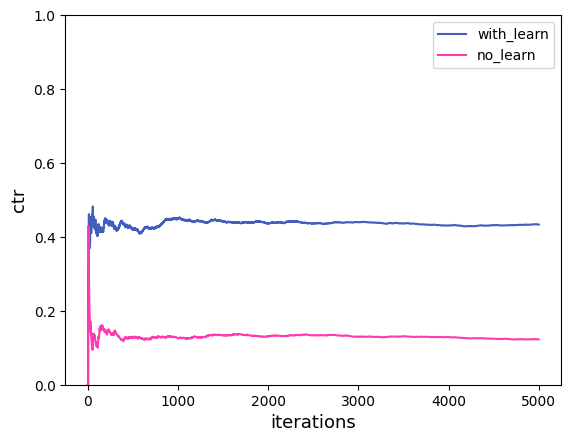

In [5]:
pref_list = [
    {
        'Tom': {
            'morning': 'politics',
            'afternoon': 'music'
        },
        'Anna': {
            'morning': 'sports',
            'afternoon': 'politics'
        }
    }
]

vw_args = [
    "--cb_explore_adf",
    "--epsilon=0.2",
]

run_scenario(pref_list, vw_args)

### VW Namespaces

```json
{
  "_label_cost": 0, 
  "_label_probability": 0.125, 
  "_label_Action": 2, 
  ... 
  "o": [{
    "click": 0, "has_return": 0
  }], 
  "a": [1, 2, 3, 4, 5, 6, 7, 8], 
  "c": {
    "User": {
      "name": "Tom", 
      "time_of_day": "morning"
    }, 
    "_multi": [
      {
        "Action": {
          "article": "politics"
        }
      }, 
      {
        "Action": {
          "article": "sports"
        },
      }
      ... 
    ]
  }, 
  "p": [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
}
```

### Interactions

- `interactions=UA` is supplied in VW arguments
- Tells VW to create additional features which are the features in the **(U)ser** namespace and **(A)ction** namespaces multiplied together
-  This allows us to learn the interaction between when certain actions are good in certain times of days and for particular users

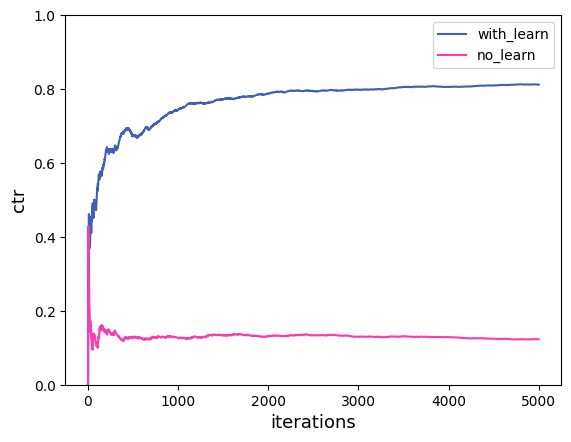

In [6]:

vw_args = [
    "--cb_explore_adf",
    "--interactions=UA",
    "--epsilon=0.2",
]

run_scenario(pref_list, vw_args)

## Scenario 2 - User with non-stationary preference

### Tom

|               |                Morning                |                Afternoon                |
| :-----------: | :-----------------------------------: | :-------------------------------------: |
|Before Olympics|                Politics               |                  Music                  |
|During Olympics|                Politics               |                  Sports                 |

### Anna
|               |                Morning                |                Afternoon                |
| :-----------: | :-----------------------------------: | :-------------------------------------: |
|Before Olympics|                Sports                 |                Politics                 |
|During Olympics|                Sports                 |                  Sports                 |

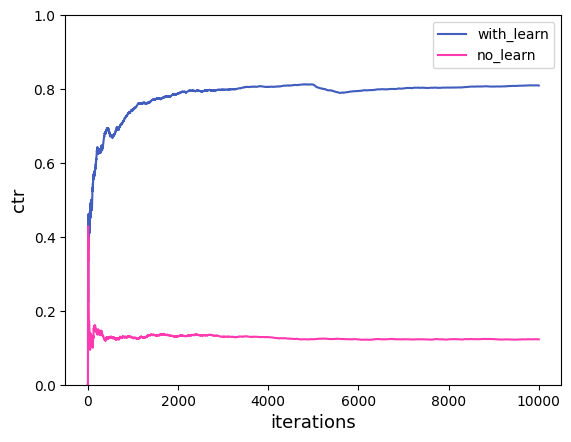

In [7]:
pref_list = [
    {
        'Tom': {
            'morning': 'politics',
            'afternoon': 'music'
        },
        'Anna': {
            'morning': 'sports',
            'afternoon': 'politics'
        }
    },
    {
        'Tom': {
            'morning': 'politics',
            'afternoon': 'sports'
        },
        'Anna': {
            'morning': 'sports',
            'afternoon': 'sports'
        }
    }
]

vw_args = [
    "--cb_explore_adf",
    "--interactions=UA",
    "--epsilon=0.2",
]

run_scenario(pref_list, vw_args)

## Scenario 3 - User likes new action

### Tom

|                Morning                |                Afternoon                |
| :-----------------------------------: | :-------------------------------------: |
|                Politics               |                  Music                  |
|                Politics               |                   Food                  |

### Anna
|                Morning                |                Afternoon                |
| :-----------------------------------: | :-------------------------------------: |
|                Sports                 |                Politics                 |
|                 Food                  |                  Sports                 |

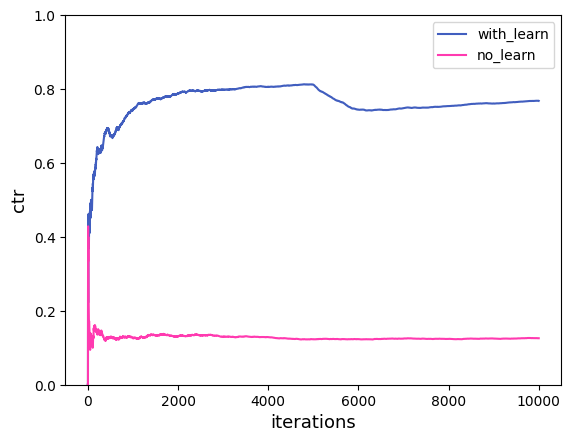

In [8]:
pref_list = [
    {
        'Tom': {
            'morning': 'politics',
            'afternoon': 'music'
        },
        'Anna': {
            'morning': 'sports',
            'afternoon': 'politics'
        }
    },
    {
        'Tom': {
            'morning': 'politics',
            'afternoon': 'food'
        },
        'Anna': {
            'morning': 'food',
            'afternoon': 'sports'
        }
    }
]

vw_args = [
    "--cb_explore_adf",
    "--interactions=UA",
    "--epsilon=0.2",
]
run_scenario(pref_list, vw_args)

### Other exploration algorithms in VW

In [30]:
%matplotlib widget

import ipywidgets as widgets
from plot_utils import plot_ctr
import threading
import matplotlib.pyplot as plt
spinner = widgets.Label(value='')

def spinning():
    import time
    symbols = ['\\', '|', '/', '-']
    i = 0
    while _running:
        spinner.value = f"Running... {symbols[i]}"
        time.sleep(0.2)
        i = (i + 1) % 4

def _sim(exploration, interaction):
    global _running
    _running = True
    display(spinner)
    thread = threading.Thread(target=spinning)
    thread.start()

    pref_list = [
        {
            'Tom': {
                'morning': 'politics',
                'afternoon': 'music'
            },
            'Anna': {
                'morning': 'sports',
                'afternoon': 'politics'
            }
        },
        {
            'Tom': {
                'morning': 'politics',
                'afternoon': 'food'
            },
            'Anna': {
                'morning': 'food',
                'afternoon': 'sports'
            }
        }
    ]

    vw_args = [
        "--cb_explore_adf",
        exploration,
        interaction,
    ]
    ctr = run_sim(pref_list, vw_args, T=20_000)
    plt.cla()
    plot_ctr([ctr], ['with_learn'])

    _running = False
    spinner.value = ''

widgets.interact(
    _sim,
    exploration=[
        '--epsilon=0.2',
        # '--bag=3',
        '--bag=4 --epsilon=0.05',
        # '--squarecb',
        '--squarecb --gamma_scale=100',
        '--squarecb --gamma_scale=0',
    ],
    interaction=[
        '--interactions=UA',
        '--interactions=::'
    ])

interactive(children=(Dropdown(description='exploration', options=('--epsilon=0.2', '--bag=4 --epsilon=0.05', …

<function __main__._sim(exploration, interaction)>

### Add in more features and update reward function

[warning] Any duplicate namespace interactions will be removed
You can use --leave_duplicate_interactions to disable this behaviour.



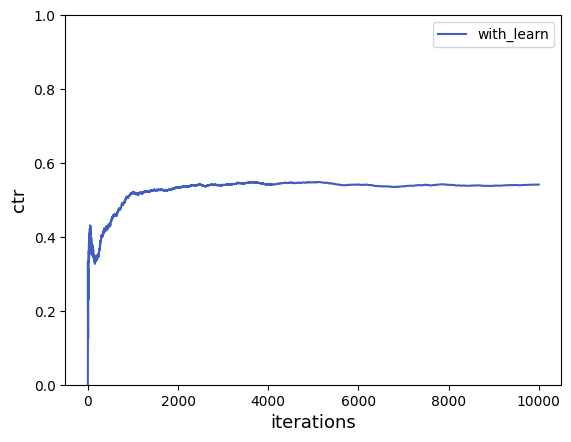

In [10]:
from plot_utils import plot_ctr
pref_list = [
    {
        'Tom': {
            'morning': 'politics',
            'afternoon': 'music'
        },
        'Anna': {
            'morning': 'sports',
            'afternoon': 'politics'
        }
    },
    {
        'Tom': {
            'morning': 'politics',
            'afternoon': 'food'
        },
        'Anna': {
            'morning': 'food',
            'afternoon': 'sports'
        }
    }
]

vw_args = [
    "--cb_explore_adf",
    "--interactions=::",
    "--epsilon=0.2",
]

ctr_scenario_4 = run_sim(pref_list, vw_args, seed=2367843, n_bad_features=64, save_log=True, feedback_reward=True)
plot_ctr([ctr_scenario_4], ['with_learn'])

### Apply Offline Evaluation Policy

In [11]:
vw_args = [
    "--cb_explore_adf",
    "--interactions=UA",
    "--learning_rate=0.5",
    "--epsilon=0.2",
]
ctr_scenario_4_cse = run_sim(pref_list, vw_args, seed=2367843, n_bad_features=64, save_log=False, feedback_reward=True)

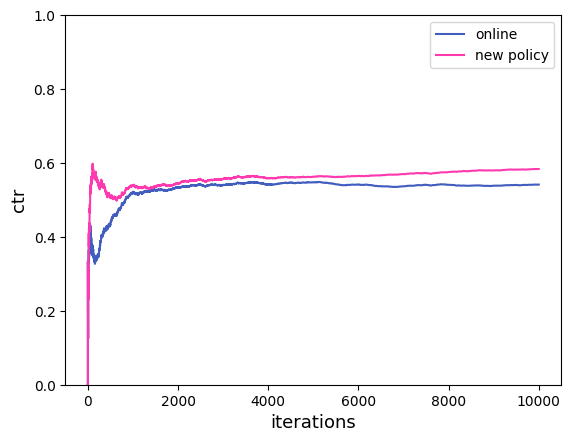

In [12]:
plot_ctr([ctr_scenario_4, ctr_scenario_4_cse], ['online', 'new policy'])